In [2]:
import codecs, re, os

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from sklearn.model_selection import cross_validate


In [3]:
def load_movies(path="../data/raw/"):
    corpus = []
    classes = []
    label = 0
    for cl in os.listdir(path):  # parcours des fichiers d'un répertoire
        for f in os.listdir(path + cl):
            txt = open(path + cl + "/" + f).read()
            corpus.append(txt)
            classes.append(label)
        label += 1  # changer de répertoire <=> changement de classe
    return np.array(corpus), np.array(classes)


X, y = load_movies()
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [4]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay


def make_pipeline(mode, model):
    if mode == "original":
        return make_imb_pipeline(CountVectorizer(), model())
    elif mode == "oversampling":
        return make_imb_pipeline(CountVectorizer(), RandomOverSampler(), model())
    elif mode == "undersampling":
        return make_imb_pipeline(
            CountVectorizer(), RandomUnderSampler(replacement=False), model()
        )
    elif mode == "regularization" and model.__name__ != "MultinomialNB":
        return make_imb_pipeline(CountVectorizer(), model(class_weight="balanced"))
    elif "regularization" in mode and model.__name__ == "MultinomialNB":
        return make_imb_pipeline(CountVectorizer(), model(fit_prior=True))
    # elif mode == "balanced + regularization" and model.__name__ != "MultinomialNB":
    #     return make_imb_pipeline(CountVectorizer(), model(C=10))
    # elif mode == "balanced + regularization" and model.__name__ == "MultinomialNB":
    #     return make_imb_pipeline(CountVectorizer(), model(fit_prior=True, alpha=0.5))
    # elif mode == "balanced ++" and model.__name__ != "MultinomialNB":
    #     weights = {-1: 100000000, 1:1}
    #     return make_imb_pipeline(CountVectorizer(), model(class_weight=weights))


## Combien de $k$ pour la cross-validation ?


In [5]:
from tqdm import tqdm
from time import time
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, cross_val_score

pipeline = make_pipeline("original", LogisticRegression)

# ideal = np.mean(cross_val_score(pipeline, X, y, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1))
# define folds to test
folds = range(2, 31)
# record mean and min/max of each set of results
means, mins, maxs, times = list(), list(), list(), list()
# evaluate each k value
for k in tqdm(folds):
    # define the test condition
    t = time()
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    # evaluate k value
    scores = cross_val_score(pipeline, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
    times.append(time() - t)
    k_mean, k_min, k_max = np.mean(scores), scores.min(), scores.max()
    # report performance
    print("> folds=%d, accuracy=%.3f (%.3f,%.3f)" % (k, k_mean, k_min, k_max))
    # store mean accuracy
    means.append(k_mean)
    # store min and max relative to the mean
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)


  3%|▎         | 1/29 [00:04<02:17,  4.92s/it]

> folds=2, accuracy=0.906 (0.904,0.907)


  7%|▋         | 2/29 [00:08<01:44,  3.86s/it]

> folds=3, accuracy=0.911 (0.907,0.917)


 10%|█         | 3/29 [00:11<01:40,  3.88s/it]

> folds=4, accuracy=0.916 (0.907,0.929)


 14%|█▍        | 4/29 [00:16<01:40,  4.00s/it]

> folds=5, accuracy=0.916 (0.894,0.931)


 17%|█▋        | 5/29 [00:21<01:45,  4.40s/it]

> folds=6, accuracy=0.920 (0.910,0.932)


 21%|██        | 6/29 [00:26<01:47,  4.68s/it]

> folds=7, accuracy=0.919 (0.897,0.936)


 24%|██▍       | 7/29 [00:32<01:49,  4.99s/it]

> folds=8, accuracy=0.923 (0.913,0.936)


 28%|██▊       | 8/29 [00:38<01:55,  5.52s/it]

> folds=9, accuracy=0.920 (0.908,0.936)


 31%|███       | 9/29 [00:46<02:06,  6.32s/it]

> folds=10, accuracy=0.921 (0.897,0.948)


 34%|███▍      | 10/29 [00:56<02:19,  7.34s/it]

> folds=11, accuracy=0.924 (0.906,0.954)


 38%|███▊      | 11/29 [01:05<02:24,  8.01s/it]

> folds=12, accuracy=0.922 (0.896,0.947)


 41%|████▏     | 12/29 [01:16<02:31,  8.90s/it]

> folds=13, accuracy=0.922 (0.907,0.944)


 45%|████▍     | 13/29 [01:27<02:29,  9.36s/it]

> folds=14, accuracy=0.923 (0.874,0.969)


 48%|████▊     | 14/29 [01:37<02:24,  9.67s/it]

> folds=15, accuracy=0.923 (0.895,0.948)


 52%|█████▏    | 15/29 [01:49<02:23, 10.26s/it]

> folds=16, accuracy=0.925 (0.894,0.964)


 55%|█████▌    | 16/29 [02:02<02:24, 11.11s/it]

> folds=17, accuracy=0.922 (0.879,0.961)


 59%|█████▊    | 17/29 [02:16<02:23, 11.95s/it]

> folds=18, accuracy=0.922 (0.889,0.961)


 62%|██████▏   | 18/29 [02:29<02:14, 12.24s/it]

> folds=19, accuracy=0.922 (0.881,0.967)


 66%|██████▌   | 19/29 [02:45<02:14, 13.43s/it]

> folds=20, accuracy=0.923 (0.857,0.966)


 69%|██████▉   | 20/29 [03:02<02:11, 14.62s/it]

> folds=21, accuracy=0.924 (0.864,0.963)


 72%|███████▏  | 21/29 [03:21<02:06, 15.80s/it]

> folds=22, accuracy=0.926 (0.876,0.972)


 76%|███████▌  | 22/29 [03:38<01:54, 16.30s/it]

> folds=23, accuracy=0.924 (0.875,0.968)


 79%|███████▉  | 23/29 [03:56<01:40, 16.68s/it]

> folds=24, accuracy=0.922 (0.852,0.972)


 83%|████████▎ | 24/29 [04:17<01:30, 18.06s/it]

> folds=25, accuracy=0.924 (0.856,0.982)


 86%|████████▌ | 25/29 [04:39<01:16, 19.10s/it]

> folds=26, accuracy=0.923 (0.877,0.969)


 90%|████████▉ | 26/29 [05:01<01:00, 20.04s/it]

> folds=27, accuracy=0.921 (0.844,0.980)


 93%|█████████▎| 27/29 [05:22<00:40, 20.28s/it]

> folds=28, accuracy=0.924 (0.861,0.973)


 97%|█████████▋| 28/29 [05:44<00:20, 20.75s/it]

> folds=29, accuracy=0.922 (0.855,0.970)


100%|██████████| 29/29 [06:07<00:00, 12.69s/it]

> folds=30, accuracy=0.923 (0.854,0.981)


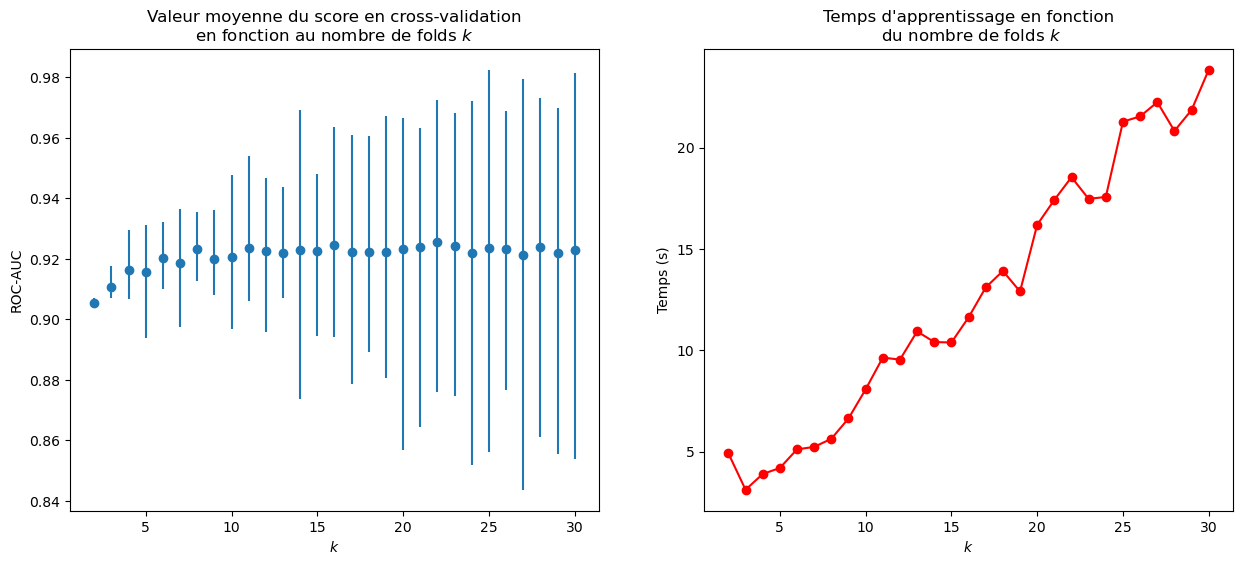

In [6]:
# line plot of k mean values with min/max error bars
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.errorbar(folds, means, yerr=[mins, maxs], fmt="o")
plt.xlabel("$k$")
plt.ylabel("ROC-AUC")
plt.title(
    "Valeur moyenne du score en cross-validation\nen fonction au nombre de folds $k$"
)
plt.subplot(122)
plt.plot(folds, times, "ro-")
plt.xlabel("$k$")
plt.ylabel("Temps (s)")
plt.title("Temps d'apprentissage en fonction\n du nombre de folds $k$")
# plot the ideal case in a separate color
# plt.plot(folds, [ideal for _ in range(len(folds))], color='r')
# show the plot
plt.savefig("../reports/figures/crossval_analysis.png", dpi=100, bbox_inches="tight")
plt.show()


## Temps d'apprentissage en fonction du vocabulaire


In [ ]:
vectorizer = CountVectorizer(ngram_range=(3, 3))
_ = vectorizer.fit_transform(X_train)
s = len(vectorizer.vocabulary_)
print(s)

times = {"nb": [], "lr": [], "svm": []}
for features in range(10000, s, 10000):
    vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=features)
    X_train_2 = vectorizer.fit_transform(X_train)
    t0 = time()
    nb_clf = MultinomialNB()
    nb_clf.fit(X_train_2, y_train)
    times["nb"].append(time() - t0)
    t0 = time()
    nb_clf = LogisticRegression(max_iter=10000)
    nb_clf.fit(X_train_2, y_train)
    times["lr"].append(time() - t0)
    t0 = time()
    nb_clf = LinearSVC(max_iter=10000)
    nb_clf.fit(X_train_2, y_train)
    times["svm"].append(time() - t0)

import matplotlib.pyplot as plt

plt.figure(figsize=(9, 7))
plt.plot(range(10000, s, 10000), times["nb"], label="Naive Bayes")
plt.plot(range(10000, s, 10000), times["lr"], label="LogReg")
plt.plot(range(10000, s, 10000), times["svm"], label="SVM")
plt.legend()
plt.xlabel("Taille du vocabulaire (en nombre de mots)")
plt.ylabel("Temps d'apprentissage (en secondes)")
plt.title(
    "Temps d'apprentissage d'un classifieur en fonction de la taille du vocabulaire"
)

plt.savefig(
    "../reports/figures/complexity_analysis_vocabulary.png",
    dpi=100,
    bbox_inches="tight",
)
plt.show()


## Learning Curves


Sur les modèles bruts (sans avoir touché aux paramètres) :


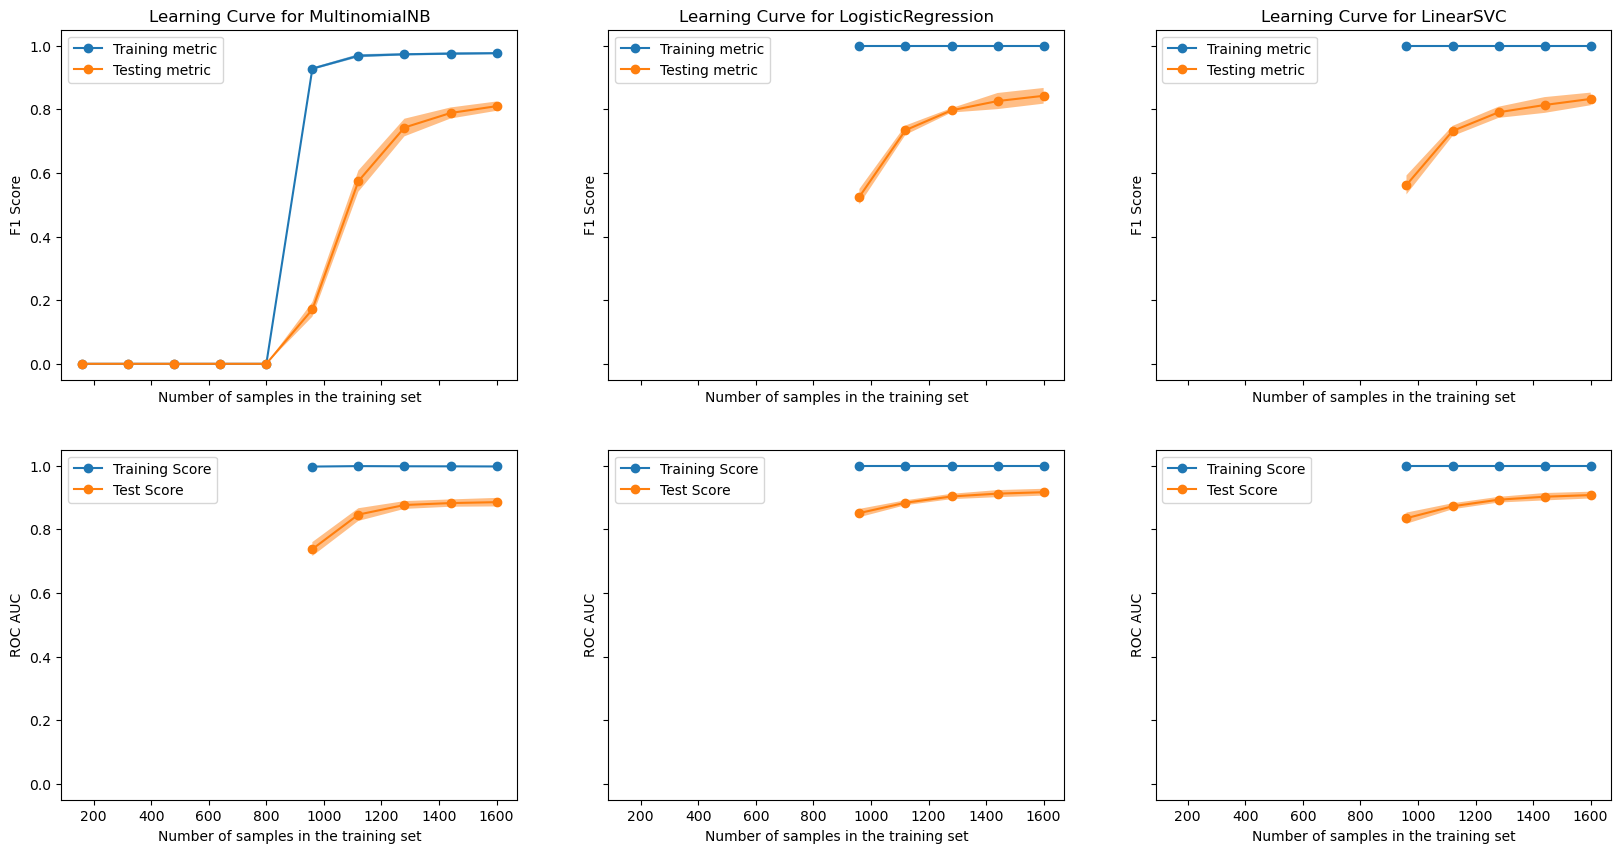

In [7]:
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

common_params_roc = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": 5,
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "scoring": "roc_auc",
    "score_name": "ROC AUC",
}

common_params_f1 = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": 5,
    "score_type": "both",
    "n_jobs": -1,
    "line_kw": {"marker": "o"},
    "std_display_style": "fill_between",
    "scoring": "f1",
    "score_name": "F1 Score",
}

models = [MultinomialNB, LogisticRegression, LinearSVC]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharex=True, sharey=True)

for ax_idx, model in enumerate(models):
    pipeline = make_pipeline("original", model)
    LearningCurveDisplay.from_estimator(pipeline, **common_params_f1, ax=ax[0, ax_idx])
    LearningCurveDisplay.from_estimator(pipeline, **common_params_roc, ax=ax[1, ax_idx])
    handles, label = ax[0, ax_idx].get_legend_handles_labels()
    ax[1, ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[0, ax_idx].set_title(f"Learning Curve for {model.__name__}")
plt.savefig("../reports/figures/learningcurve.png", dpi=100, bbox_inches="tight")


Après avoir optimisé les paramètres :


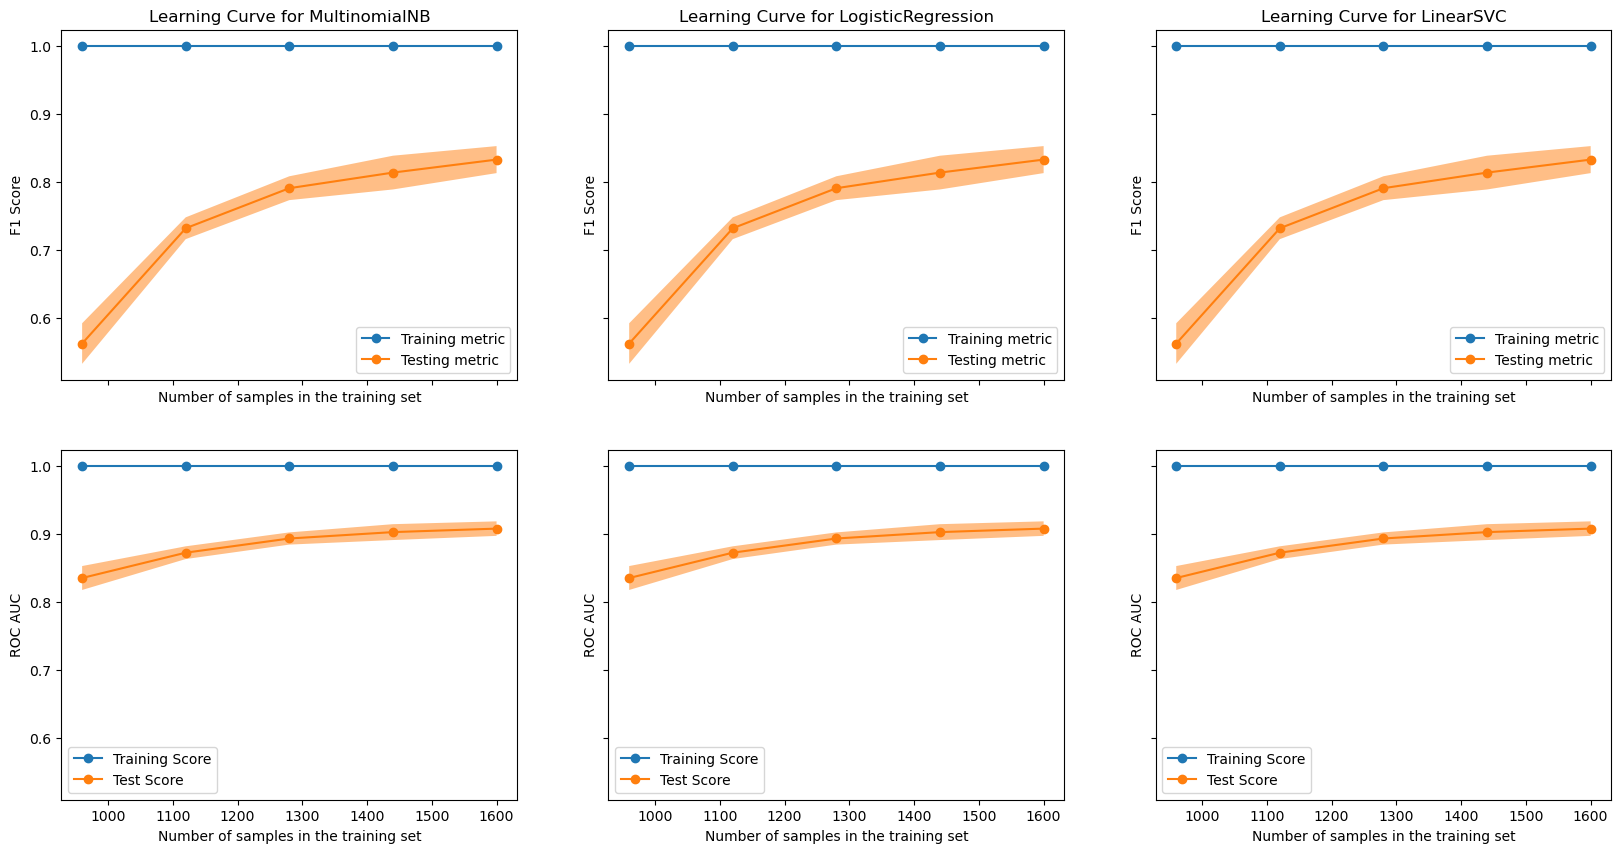

In [8]:
import joblib

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20, 10), sharex=True, sharey=True)

for ax_idx, model in enumerate(models):
    d = joblib.load(f"../gridsearch/results/part2_hrscv_{model.__name__}.pkl")
    LearningCurveDisplay.from_estimator(pipeline, **common_params_f1, ax=ax[0, ax_idx])
    LearningCurveDisplay.from_estimator(pipeline, **common_params_roc, ax=ax[1, ax_idx])
    handles, label = ax[0, ax_idx].get_legend_handles_labels()
    ax[1, ax_idx].legend(handles[:2], ["Training Score", "Test Score"])
    ax[0, ax_idx].set_title(f"Learning Curve for {model.__name__}")
plt.savefig("../reports/figures/learningcurve_opti.png", dpi=100, bbox_inches="tight")


## Complexity analysis


In [9]:
from sklearn.model_selection import learning_curve

common_params = {
    "X": X,
    "y": y,
    "train_sizes": np.linspace(0.1, 1.0, 10),
    "cv": 5,
    "n_jobs": 6,
    "return_times": True,
    "scoring": "f1",
}

naive_bayes = make_pipeline("original", MultinomialNB)
lr = make_pipeline("original", LogisticRegression)
svc = make_pipeline("original", LinearSVC)

train_sizes, _, test_scores_nb, fit_times_nb, score_times_nb = learning_curve(
    naive_bayes, **common_params
)

train_sizes, _, test_scores_lr, fit_times_lr, score_times_lr = learning_curve(
    lr, **common_params
)
train_sizes, _, test_scores_svm, fit_times_svm, score_times_svm = learning_curve(
    svc, **common_params
)


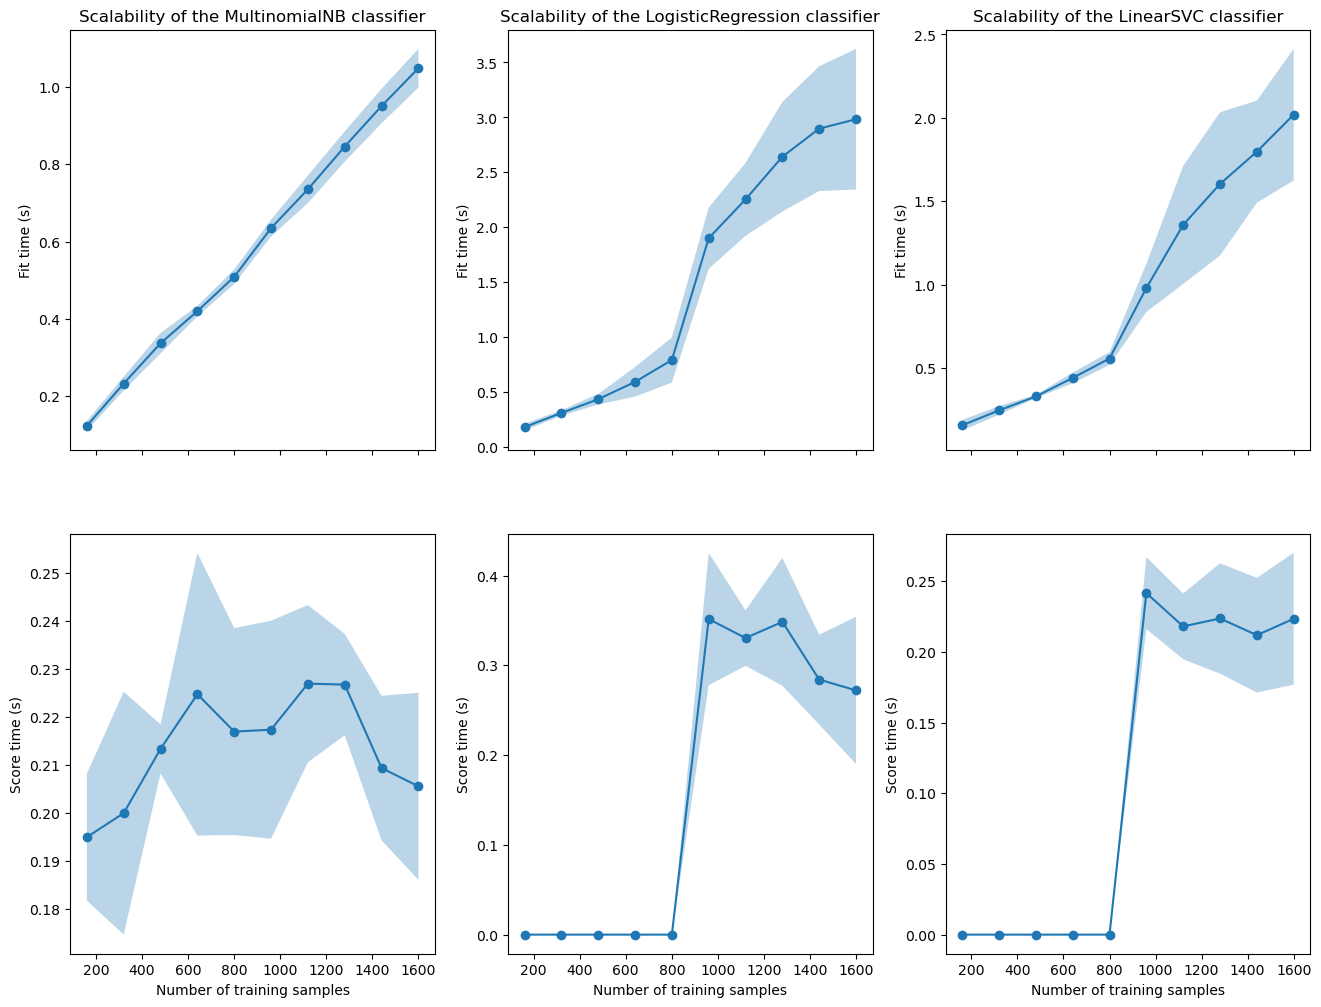

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(16, 12), sharex=True)


for ax_idx, (fit_times, score_times, estimator) in enumerate(
    zip(
        [fit_times_nb, fit_times_lr, fit_times_svm],
        [score_times_nb, score_times_lr, score_times_svm],
        ["MultinomialNB", "LogisticRegression", "LinearSVC"],
    )
):
    # scalability regarding the fit time
    ax[0, ax_idx].plot(train_sizes, fit_times.mean(axis=1), "o-")
    ax[0, ax_idx].fill_between(
        train_sizes,
        fit_times.mean(axis=1) - fit_times.std(axis=1),
        fit_times.mean(axis=1) + fit_times.std(axis=1),
        alpha=0.3,
    )
    ax[0, ax_idx].set_ylabel("Fit time (s)")
    ax[0, ax_idx].set_title(f"Scalability of the {estimator} classifier")

    # scalability regarding the score time
    ax[1, ax_idx].plot(train_sizes, score_times.mean(axis=1), "o-")
    ax[1, ax_idx].fill_between(
        train_sizes,
        score_times.mean(axis=1) - score_times.std(axis=1),
        score_times.mean(axis=1) + score_times.std(axis=1),
        alpha=0.3,
    )
    ax[1, ax_idx].set_ylabel("Score time (s)")
    ax[1, ax_idx].set_xlabel("Number of training samples")

plt.savefig(
    "../reports/figures/complexity_analysis_nsamples.png", dpi=100, bbox_inches="tight"
)


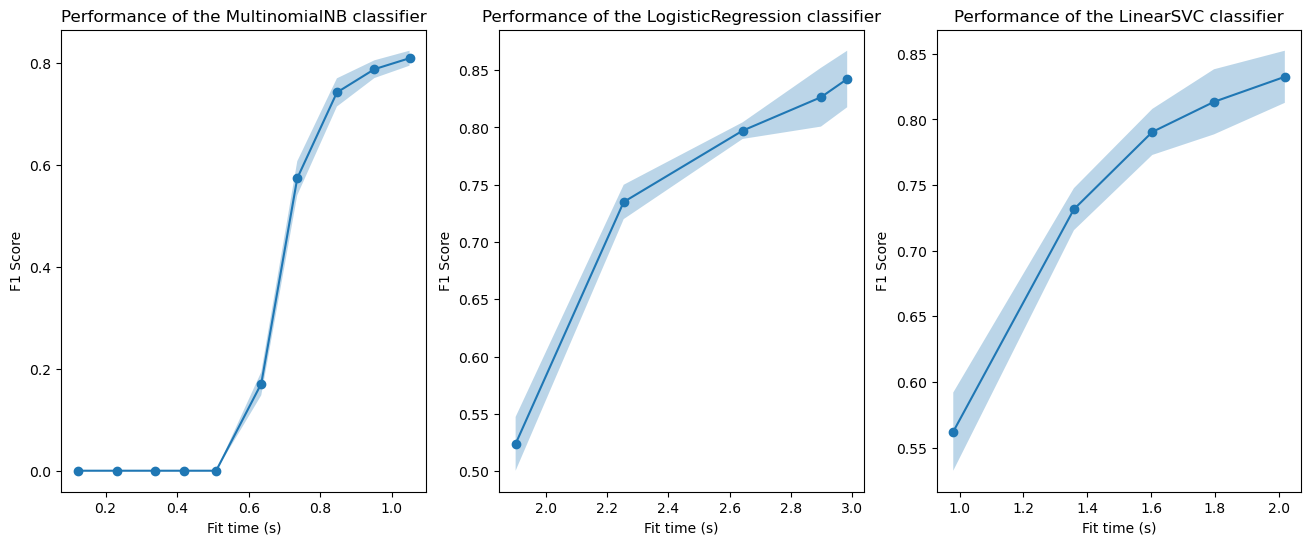

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))

for ax_idx, (fit_times, test_scores, estimator) in enumerate(
    zip(
        [fit_times_nb, fit_times_lr, fit_times_svm],
        [test_scores_nb, test_scores_lr, test_scores_svm],
        ["MultinomialNB", "LogisticRegression", "LinearSVC"],
    )
):
    ax[ax_idx].plot(fit_times.mean(axis=1), test_scores.mean(axis=1), "o-")
    ax[ax_idx].fill_between(
        fit_times.mean(axis=1),
        test_scores.mean(axis=1) - test_scores.std(axis=1),
        test_scores.mean(axis=1) + test_scores.std(axis=1),
        alpha=0.3,
    )
    ax[ax_idx].set_ylabel("F1 Score")
    ax[ax_idx].set_xlabel("Fit time (s)")
    ax[ax_idx].set_title(f"Performance of the {estimator} classifier")

plt.savefig(
    "../reports/figures/complexity_analysis_accuracy.png", dpi=100, bbox_inches="tight"
)
plt.show()


## ROC-AUC Curves


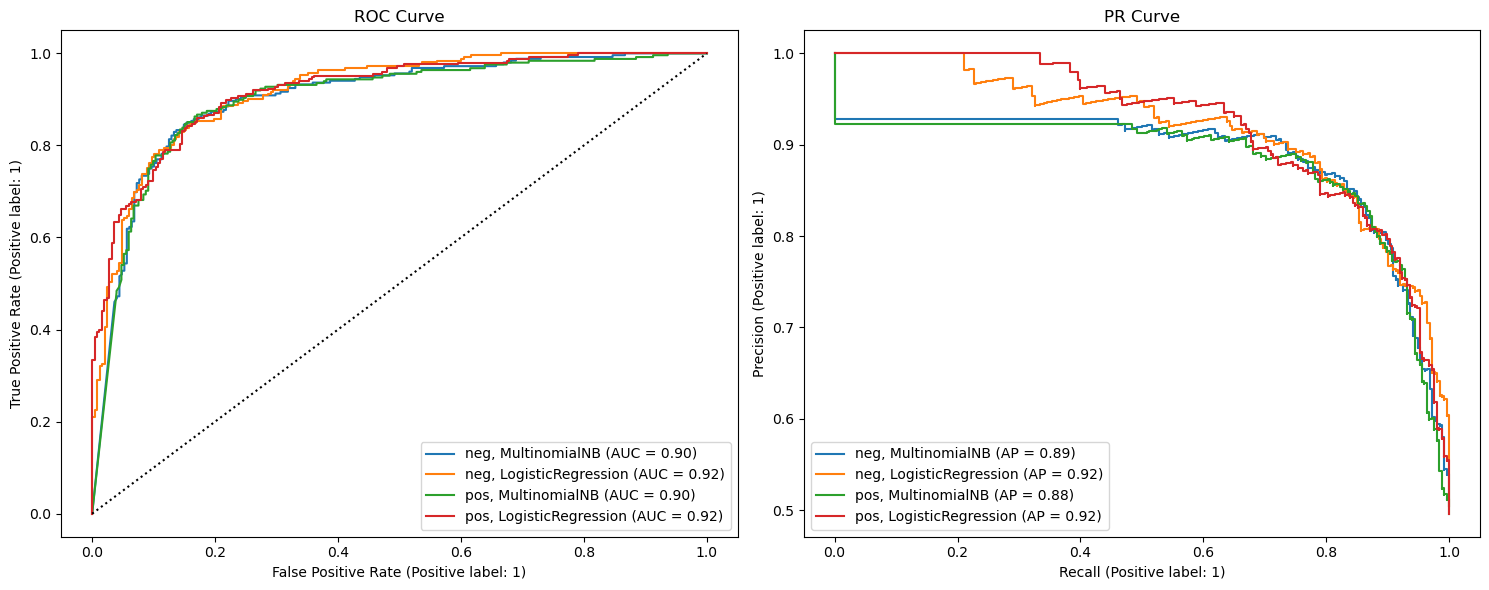

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

y_onehot_test = pd.get_dummies(y_test).to_numpy()

models = [MultinomialNB, LogisticRegression]

classes = ["neg", "pos"]
for class_id, class_name in enumerate(classes):

    for i, model in enumerate(models):
        pipeline = make_pipeline("original", model)
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict_proba(X_test)
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_pred[:, class_id],
            name=f"{class_name}, {model.__name__}",
            ax=ax[0],
        )
        PrecisionRecallDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_pred[:, class_id],
            name=f"{class_name}, {model.__name__}",
            ax=ax[1],
        )
ax[0].set_title(f"ROC Curve")
ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
ax[1].set_title(f"PR Curve")
plt.tight_layout()
plt.savefig(f"../reports/figures/roc_curve.png", dpi=100, bbox_inches="tight")
plt.show()


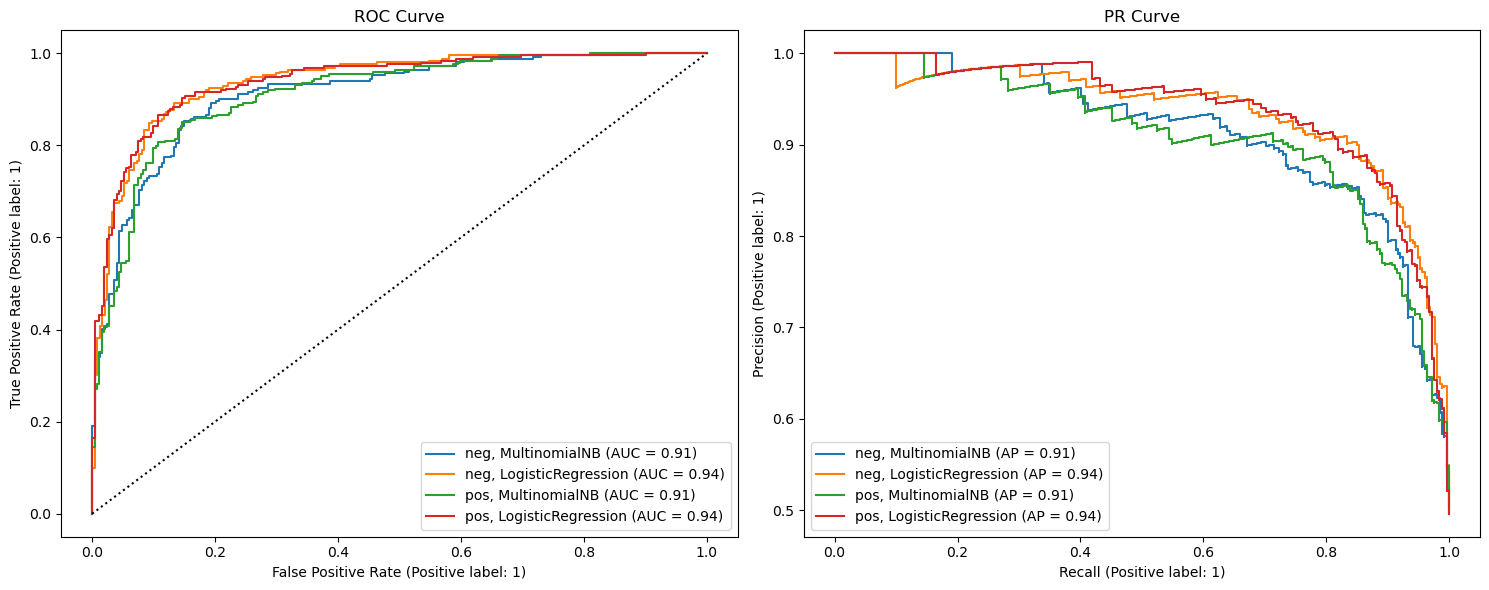

In [14]:
import joblib

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

y_onehot_test = pd.get_dummies(y_test).to_numpy()

models = [MultinomialNB, LogisticRegression]

classes = ["neg", "pos"]
for class_id, class_name in enumerate(classes):

    for i, model in enumerate(models):
        pipeline = joblib.load(
            f"../gridsearch/results/part2_hrscv_{model.__name__}_oui.pkl"
        ).best_estimator_
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict_proba(X_test)
        RocCurveDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_pred[:, class_id],
            name=f"{class_name}, {model.__name__}",
            ax=ax[0],
        )
        PrecisionRecallDisplay.from_predictions(
            y_onehot_test[:, class_id],
            y_pred[:, class_id],
            name=f"{class_name}, {model.__name__}",
            ax=ax[1],
        )
ax[0].set_title(f"ROC Curve")
ax[0].plot([0, 1], [0, 1], "k:", label="(AUC = 0.5)")
ax[1].set_title(f"PR Curve")
plt.tight_layout()
plt.savefig(f"../reports/figures/roc_curve_opti.png", dpi=100, bbox_inches="tight")
plt.show()
